In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA

## Network
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd
import csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_modele'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [29]:
## marker gene
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
marker_gene_dic['myeloid']= ['S100A8','S100A9','MNDA','FGL2','CLEC7A','CD6S','IFI30']
marker_gene_dic['Megakaryocytes']= ['PF4','PPBP']

def get_index(temp_list,gene_list):
    temp_index = []
    for i in temp_list:
        temp_index.append(np.where(gene_list==i)[0][0])
    return temp_index

def marker_gene_heatmap(marker_gene_dic,gene_list,val,title='',show_val=False,output_folder='.'):
    def strip0(s):
        if s[0]=='0':
            return s[1:]
        elif s[0] == '-' and s[1] =='0':
            return '-'+s[2:]
        else:
            return s
    marker_gene_list = []
    marker_gene_group = []
    for i_key,key in enumerate(marker_gene_dic):
        for gene in marker_gene_dic[key]:
            if gene in gene_list:
                marker_gene_list.append(gene)
                marker_gene_group.append(key+':'+gene)
    n_gene = len(marker_gene_list)
    idx_ = get_index(marker_gene_list,gene_list)
    val = val[idx_,:][:,idx_]
    plt.figure(figsize=[12,12])
    plt.imshow(val,vmin=-1,vmax=1)  
    
    if show_val:    
        plt.xticks(np.arange(n_gene),marker_gene_list,rotation=45,fontsize=15)
        plt.yticks(np.arange(n_gene),marker_gene_list,fontsize=15)
        for i in range(n_gene):
            for j in range(n_gene):
                text = plt.text(j,i,'%s'%strip0('%0.2f'%val[i,j]),
                               ha="center", va="center", color="w",fontsize=12)
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=12) 

    else:
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(output_folder+'/'+title+'.png')
    plt.savefig(output_folder+'/'+title+'.pdf')
    plt.show()

In [30]:
## load the data 
data = dl.load_10x_4k()
data.var_names_make_unique()
sc.pp.filter_genes(data,min_counts=0.0001*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)

## filter and calculate PC
size_factor = sd.dd_size_factor(data,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
gene_list = np.array(data.var_names)[var_dd>0.1]
print(len(gene_list))
data = data[:,list(gene_list)]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=19773, Nr=4349.04, Nr_bar=0.22
#time start: 0.0s
n_cell=4340, n_gene=19773
#total: 0.27s
791


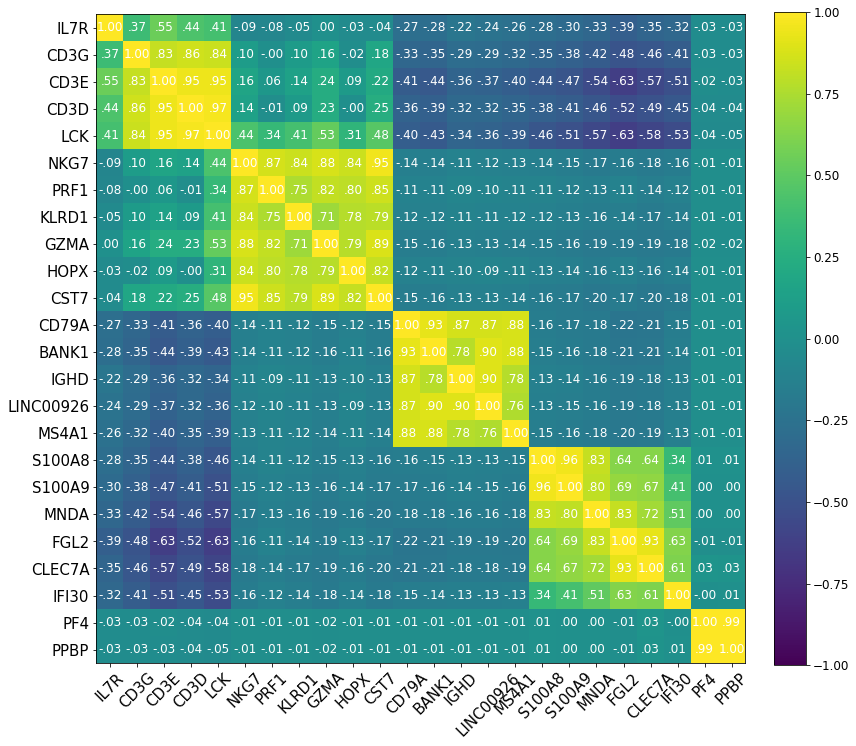

In [31]:
marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd,title='PC_dd_full',show_val=True,output_folder=output_folder)

#time start: 0.0s
n_cell=4340, n_gene=791, Nr=3224.3
#total: 3.17s


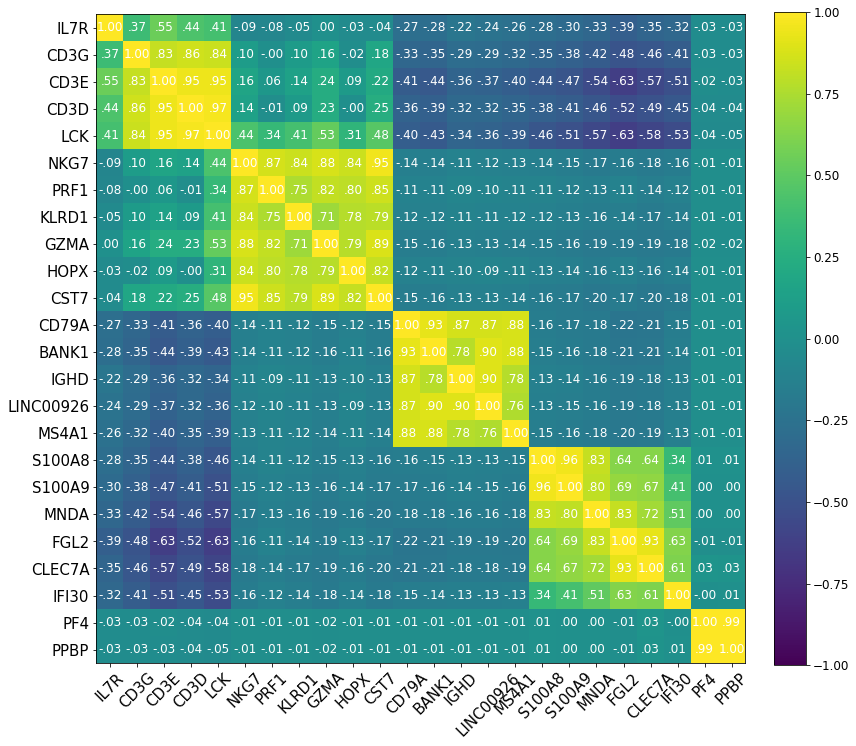

In [32]:
# full result for PC_dd
size_factor = sd.dd_size_factor(data,verbose=False)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data,size_factor=size_factor,PC_prune=False)
marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd,title='PC_dd_full',show_val=True,output_folder=output_folder)

subsample_rate: 1.00


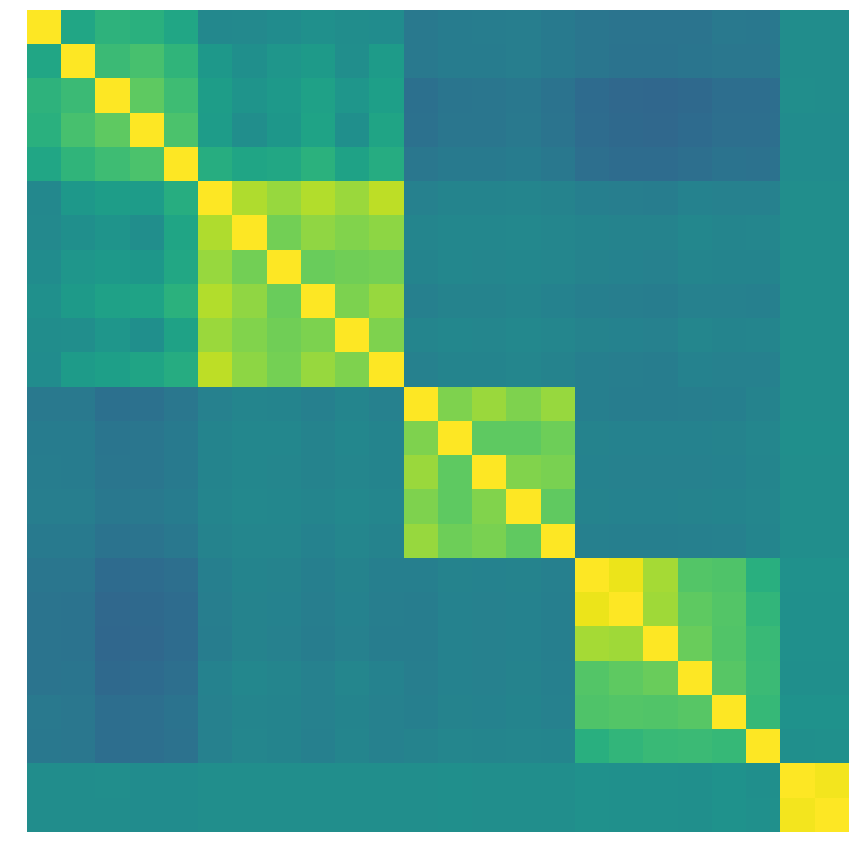

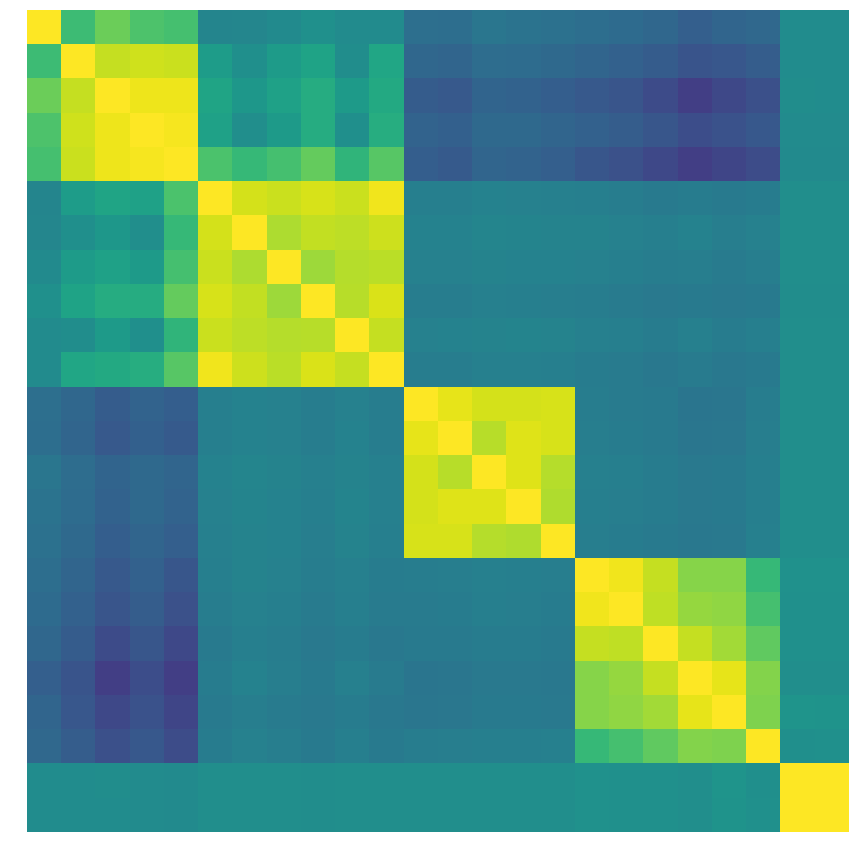

subsample_rate: 0.25


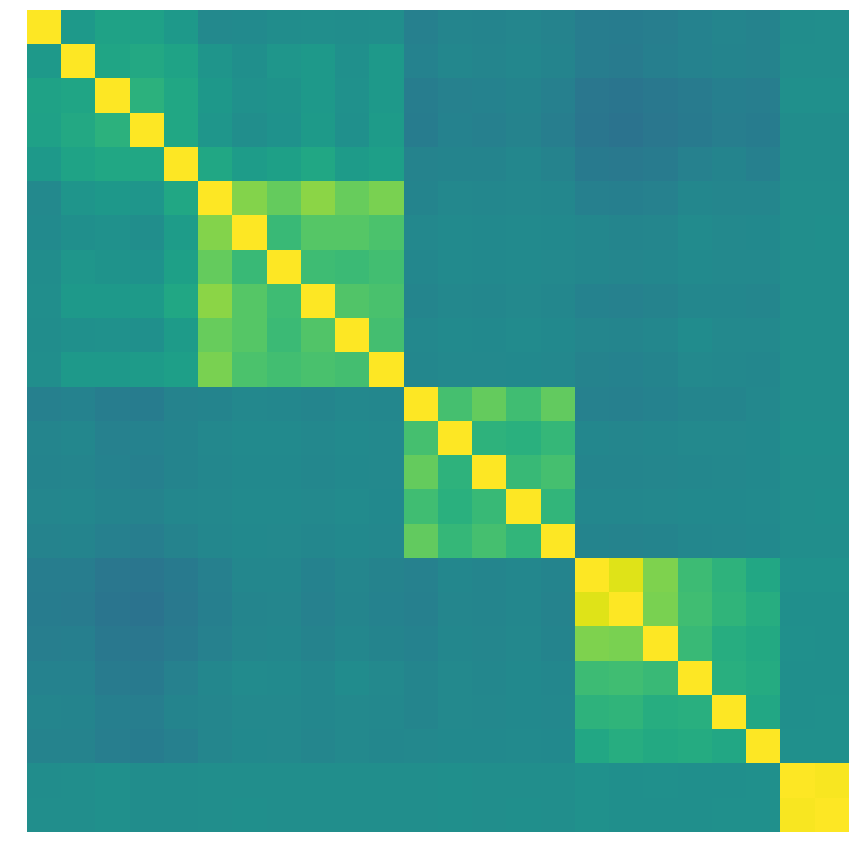

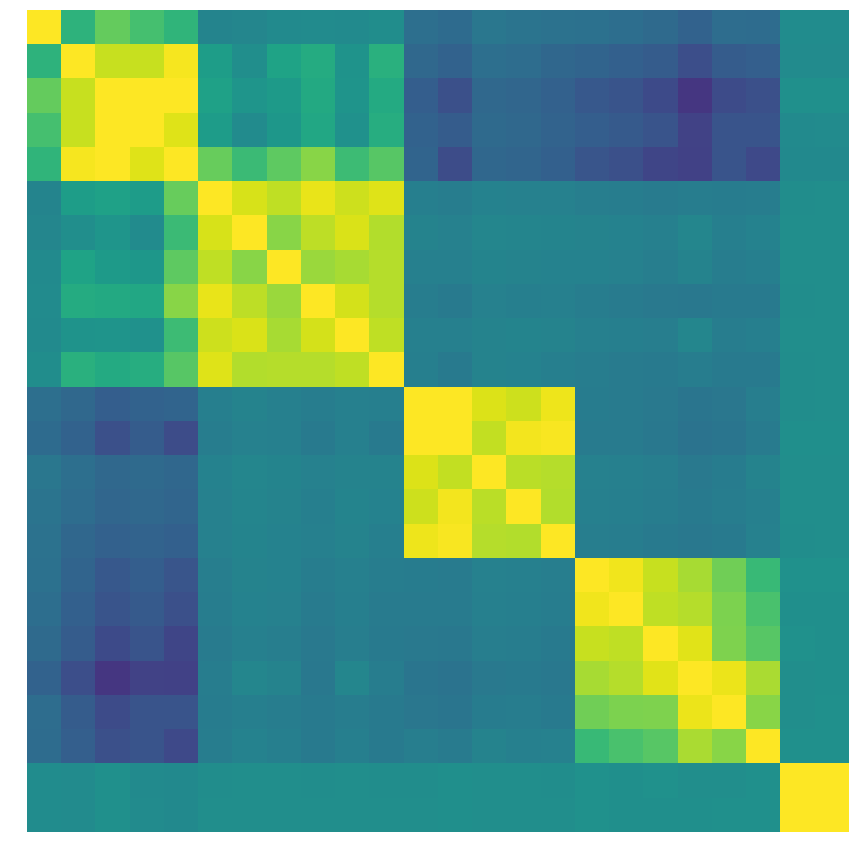

subsample_rate: 0.10


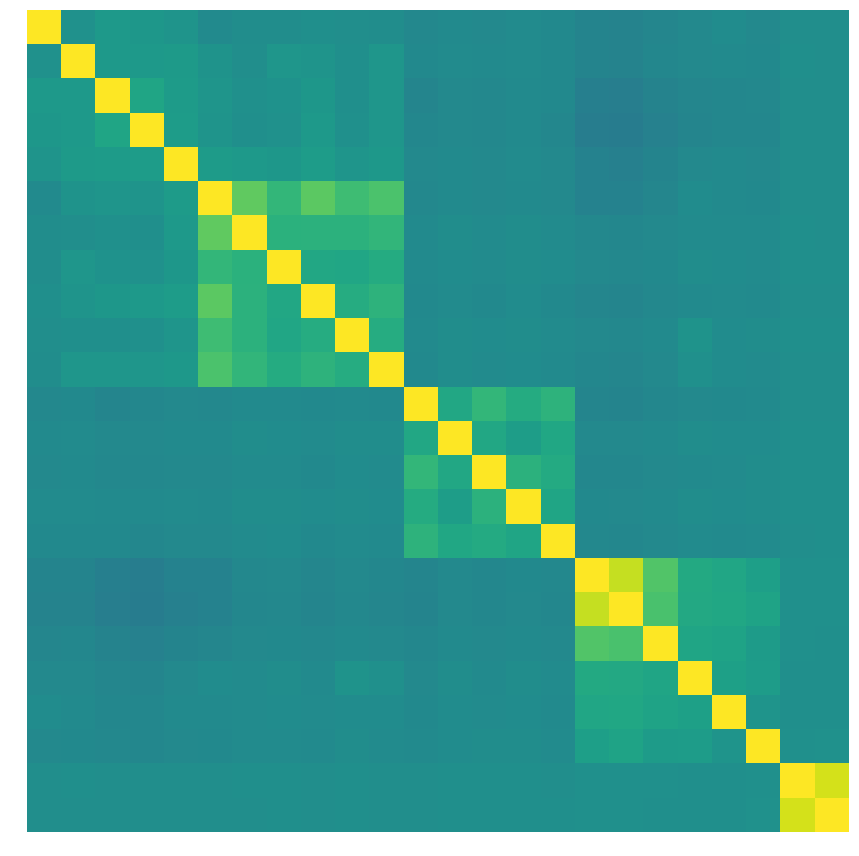

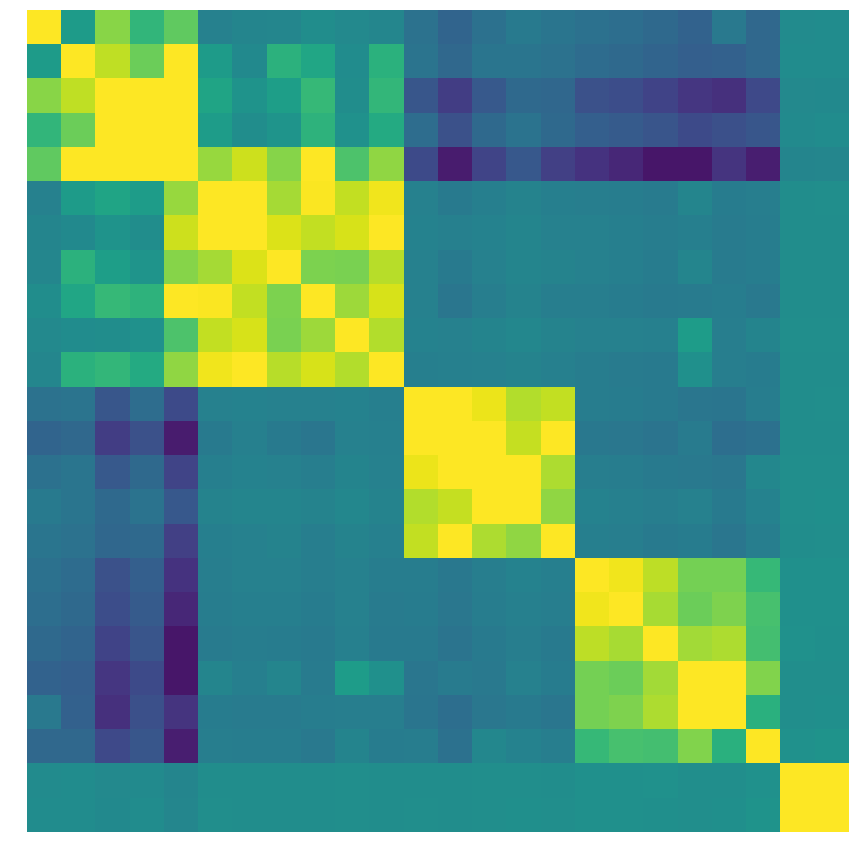

subsample_rate: 0.05


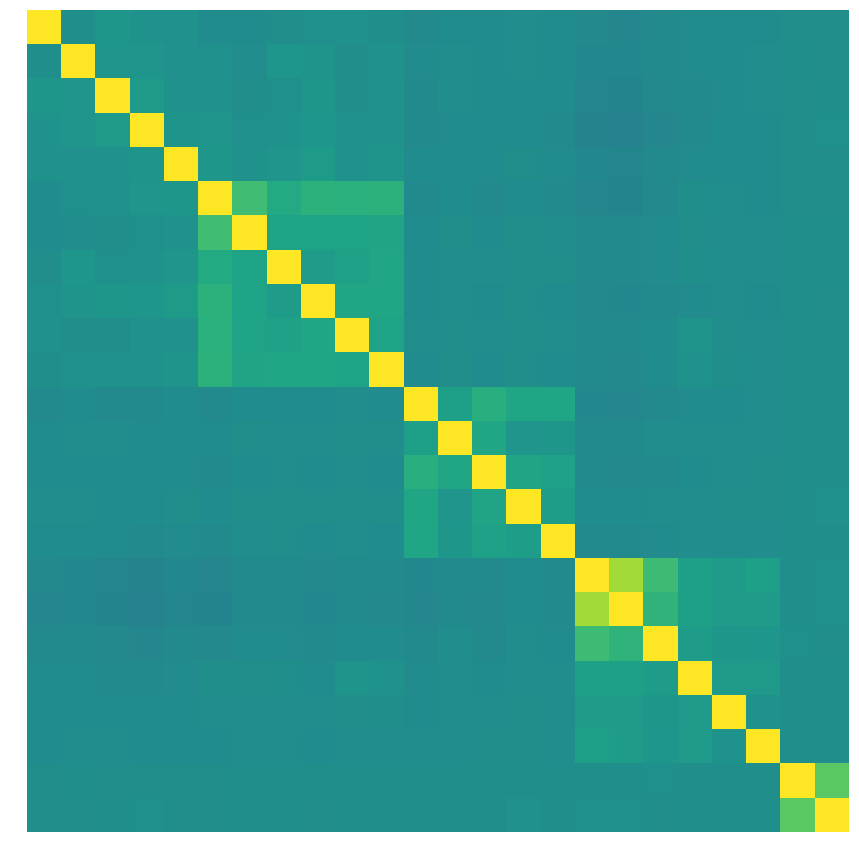

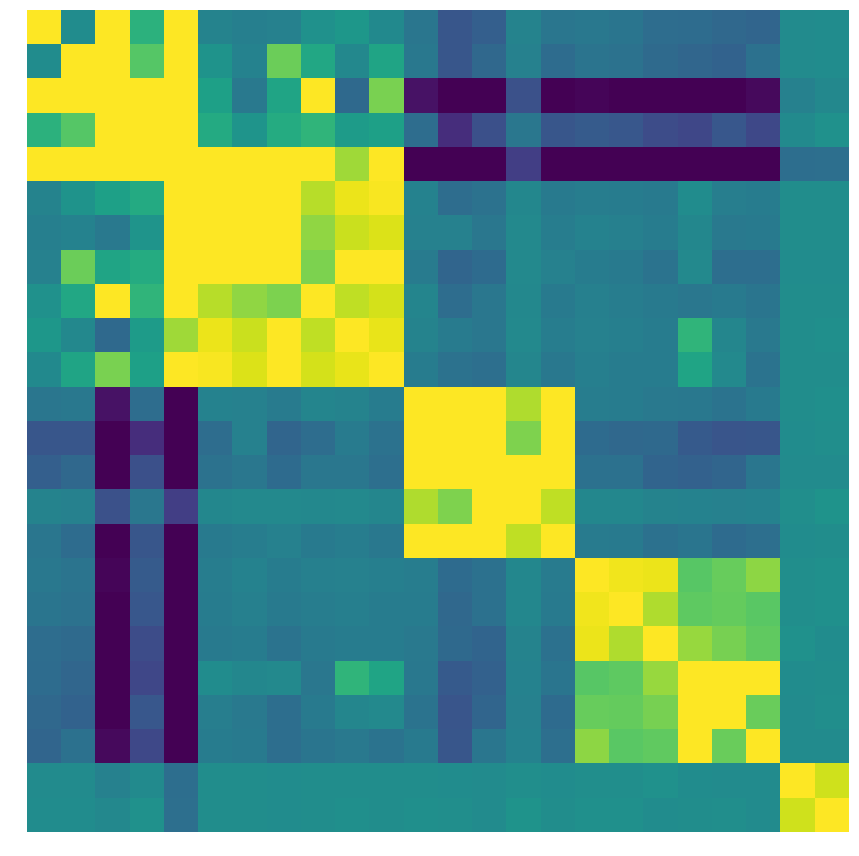

In [33]:
# subsample experiments
for subsample_rate in [1,0.25,0.1,0.05]:
    print('subsample_rate: %0.2f'%subsample_rate)
    if subsample_rate == 1:
        data_sub = data
    else:
        ## subsample the data 
        Nr_new = Nr*subsample_rate
        Nc_new = int(Nc)
        data_sub = sd.subsample_anndata(data,Nr_new,Nc_new,verbose=False)
    # calculate PC
    size_factor = sd.dd_size_factor(data_sub,verbose=False)
    mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data_sub,size_factor=size_factor,verbose=False)
    mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data_sub,size_factor=size_factor,PC_prune=False,verbose=False)
    marker_gene_heatmap(marker_gene_dic,gene_list,PC_ml,title='PC_ml_%0.2f'%subsample_rate,show_val=False,
                       output_folder=output_folder)
    marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd,title='PC_dd_%0.2f'%subsample_rate,show_val=False,
                       output_folder=output_folder)